## Credits
Steam - https://store.steampowered.com/search/?category1=998

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Download packages

In [1]:
#pip install selenium

In [2]:
#conda install -c conda-forge imbalanced-learn

## Imports

In [3]:
from time import sleep
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import numpy as np
import random
import re
from datetime import datetime
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

# show several prints in one cell. This will allow us to condence every trick in one cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Save and load data from CSV

In this section, we are saving and loading data from a csv in order to save time on each run.

#### Save to csv

Save to CSV file

In [4]:
def save_to_csv(file_name, dataset):
    dataset.to_csv(file_name)

Save data before cleanup

In [5]:
# save_to_csv("all_games_data.csv", df)

Save data after cleanup

In [6]:
# save_to_csv("all_games_data_clean.csv", new_df)

#### Load from csv

Load dataset from CSV

In [7]:
def load_csv_from_project(file_name):
    return pd.read_csv(file_name)

Load data before cleanup

In [8]:
df = load_csv_from_project("all_games_data.csv").iloc[:,1:]

Load data after cleanup

In [9]:
new_df = load_csv_from_project("all_games_data_clean.csv").iloc[:,1:]

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Helper Functions

When we get the data from the website (in our case, Steam), we immediately save the object to a file in order to prevent a misatke and rerun the scrapper again.

In [10]:
def write_soup_to_file(file_name : str, soup : BeautifulSoup):
    with open(file_name, "w", encoding='utf-8') as file:
        file.write(str(soup))

We used it once in order to load soup. We prefer to use [CSV](#Save-and-load-data-from-CSV) in oreder to load and save because it's a lot faster and saves time.

In [11]:
def load_soup_object(html_file_name : str):
    with open(html_file_name, "r", encoding='utf8') as file:
        soup = BeautifulSoup(file, "html.parser")
    return soup

These two functions are made in order to check if the 'num' is a float or an int.

In [12]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [13]:
def isint(num):
    try:
        int(num)
        return True
    except ValueError:
        return False

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Crawling With Selenium & BeautifulSoup

When diving into web scraping in Python, the choice is inevitably between two libraries: BeautifulSoup and Selenium.

While BeautifulSoup is quite practical for breaking down html pages, Selenium, being a headless driver, can do this and much more: it can type search queries into Google, scrape JS scripts, loop through pages one by one, etc.

Moreover, it becomes useful when web pages load content only upon scrolling.
Loading content upon scrolling speeds up the page loading time and offers the best user experience.

We used the Firefox driver in order to use SELENUIM.

In [14]:
def get_driver_Firefox():
    return webdriver.Firefox()  

We faced the infinite scroll problem with Selenium.

But it wasn't enough due to blocking from the Steam website. In order to overcome this problem, we used random timing to scroll.

In [15]:
def infinite_scroll(driver : webdriver.firefox.webdriver.WebDriver):
    
    _isScrolling = True
    SCROLL_PAUSE_TIME = 0.8
    
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    while _isScrolling:
                
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    
        # Wait to load page
        sleep(SCROLL_PAUSE_TIME)
        SCROLL_PAUSE_TIME = random.uniform(0.8,3)
        
        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
                
        if new_height == last_height:
            #Another check
            sleep(20)
            new_height = driver.execute_script("return document.body.scrollHeight")
            
            if new_height == last_height:            
                _isScrolling = False
                                
        last_height = new_height

We used Selenium in order to scroll until the bottom, then BeautifulSoup in order to get in action and read all the HTML we needed for our data.

In [16]:
def selenium_scrapping():
    url = "https://store.steampowered.com/search/?category1=998"
    driver = get_driver_Firefox()
    
    driver.get(url)
    driver.maximize_window()
    
    # Wait for the page to fully render before parsing it
    sleep(5)
    
    infinite_scroll(driver)
    
    print("Finish scroling... initialize BeautifulSoup")
    
    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    #quits the driver instance, closing every associated window, which is opened.
    driver.quit()

The selenium_scraping method takes a lot of time because of the number of games we have to scrape, so after scraping the first time, we used [CSV](#Save-and-load-data-from-CSV).

In [17]:
#selenium_scrapping()

#### Save BeautifulSoup to HTML

In [18]:
#write_soup_to_file("All_Games.html", soup)

#### Load BeautifulSoup from HTML

In [19]:
#soup = load_soup_object("All_Games.html")

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Data Acquisition

Here we are converting the HTML that was created from the BeautifulSoup into a lovely Dataframe we can work with in order to start beating the game:)

In [20]:
# If tag exist return 1 else 0.
def game_tag_exist(game , tag : str, classTag : str):
    if game.find(tag, attrs={"class",classTag}):
        return 1
    return 0

In [21]:
# returns the tag value or nan if the tag doesn't exist or is empty.
def game_get_text_tag(game, tag :str , classTag : str):
    return game.find(tag, attrs={"class", classTag}).get_text().strip()

In [22]:
# Scrape with BeautifulSoup and aciruque all the relevant data for our project.
def game_val_tag(game, tag :str , classTag : str):
    if game_tag_exist(game, tag, classTag):
        val = game_get_text_tag(game, tag, classTag)
        return np.nan if val == '' else val
        
    return np.nan

In [23]:
# handle tag with price and with or without discount
def game_prices(game, tag :str , classTag : str):
    prices = [np.nan]
    price_text = game_val_tag(game, "div", "search_price")
    if price_text is not np.nan:        
        if '₪' in price_text:
            prices = price_text.split('₪')
            prices.pop(0)
            if isfloat(prices[0]) is False:
                # price with ',' like 1,850.00
                if ',' in prices[0] :
                    prices[0] = float(prices[0].replace(',', ''))
                # A price like '49.00Free' with a 70% discount is irrelevant (there are only two like this).
                else:
                    prices = [np.nan]
            else:
                prices = [float(i) for i in prices]
        else:
            #free games
            prices = [float(0)]
            
    return prices
        

In [24]:
# Scrape with BeautifulSoup and aciruque all the relevant data for our project.
def scrape_games(soup : BeautifulSoup):
    game_title = list()
    game_win_support = list()
    game_mac_support = list()
    game_linux_support = list()    
    game_vr_only = list()
    game_vr_supported = list()
    game_relese_date = list()
    game_review = list()
    game_discount = list()
    game_price_discount = list()
    game_price = list()    
    
    all_games = soup("a",attrs={"class":"search_result_row"})    
    for game in all_games:
        game_title.append(game_val_tag(game, 'span', 'title'))
        game_win_support.append(game_tag_exist(game,'span', "win"))
        game_mac_support.append(game_tag_exist(game,'span', "mac"))
        game_linux_support.append(game_tag_exist(game,'span', "linux"))
        game_vr_only.append(game_tag_exist(game,'span', "vr_required"))
        game_vr_supported.append(game_tag_exist(game,'span', "vr_supported"))
        game_relese_date.append(game_val_tag(game, "div", "search_released"))
        game_review.append(game.find("span", attrs={"class",'search_review_summary'})['data-tooltip-html'] if game_tag_exist(game,'span', "search_review_summary") else np.nan)
        game_discount.append(game_val_tag(game, "div", "search_discount"))
        
        prices = game_prices(game, "div", "search_price")       
        game_price.append(prices[0])
        game_price_discount.append(prices[0] if len(prices) == 1 else prices[1])
         
    return pd.DataFrame({"title":game_title, "win_support":game_win_support
                         , "mac_support":game_mac_support, "linux_support":game_linux_support,
                         "vr_only":game_vr_only, "vr_supported":game_vr_supported,
                           "relese_date": game_relese_date, "review":game_review,
                         "discount":game_discount , "price_discount":game_price_discount ,"price":game_price })

We are loading our data from [CSV](#Save-and-load-data-from-CSV) in order to avoid rerunning the scraper every time

In [25]:
#df = scrape_games(soup)

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Data Cleaning

In this section we are taking our Dataframe we have prepared and starting to clean the mess.

#### Handle Missing Values

Drop missing values

In [26]:
def drop_missing_values(df : pd.DataFrame, columns :list):
    df_copy = df.copy()
    df_copy.dropna(subset=columns, inplace = True)
    return df_copy

Fill missing values

In [27]:
def fill_na_values(df : pd.DataFrame, col:str, val):
    df_copy = df.copy()
    df_copy[col].fillna(val, inplace = True)
    return df_copy

Clean the discount column by removing the extra unwanted characters that are appended to each value.

In [28]:
def discount_clean(df : pd.DataFrame):
    df_copy = df.copy()
    df_copy['discount'] = [int(re.sub("[-%]" ,"", str(discount))) for discount in df_copy['discount']]
    return df_copy

Clean the review column by splitting the values into 3 different main columns:

1. overall_review_- The overall review we have on the game.
2. percentage_positive_total_reviewed - The percentage of reviews that are positive.
3. total_reviewed-Total review for a game

In [29]:
def review_clean(df : pd.DataFrame):
    df_copy = df.copy()
    
    overall_review = list()
    percentage_positive_total_reviewed = list()
    total_reviewed = list()
    
    for rev in df_copy['review']:
        #For removing if else
        splited_data = ['no reviews','0 0 0 0']
        if rev is not np.nan:
            splited_data = rev.split('<br>')    
                
        reviewers = splited_data[1].split(' ')            
        overall_review.append(splited_data[0])        
        percentage_positive_total_reviewed.append(int(reviewers[0].replace('%','')))
        total_reviewed.append(int(reviewers[3].replace(',','')))
        
    df_copy['overall_review'] = overall_review
    df_copy['percentage_positive_total_reviewed'] = percentage_positive_total_reviewed
    df_copy['total_reviewed'] = total_reviewed
    
    df_copy.drop(['review'], axis = 1, inplace=True)
    
    return df_copy

Clean the release_date column by splitting the values into 3 different main columns:
1. day
2. month
3. year

This will helps us later in the [Model Section](#Model).

In [30]:
def release_date_clean(df : pd.DataFrame):
    df_copy = df.copy()
    
    day = list()
    month = list()
    year = list()
    rows_to_remove = list()
    
    for idx in df_copy.relese_date.index.values:
        date_splited = df_copy.relese_date[idx].split(' ') 
        if len(date_splited) == 3 and isint(date_splited[0]):
            final_date = datetime.strptime(df_copy.relese_date[idx].replace(',',''), '%d %b %Y').strftime('%d %m %Y')
            date_splited = final_date.split(' ')
            day.append(date_splited[0])
            month.append(date_splited[1])
            year.append(date_splited[2])
        else:
            rows_to_remove.append(idx)
            
    df_copy.drop(index=rows_to_remove, inplace=True)
    df_copy.drop(['relese_date'], axis = 1, inplace=True)
    df_copy['day'] = list(map(int, day))
    df_copy['month'] = list(map(int, month))
    df_copy['year'] = list(map(int, year))
    
    return df_copy

Cleaning the data by using the functions above.

In [31]:
cols_with_missing_values = ['price','relese_date','title']
new_df = drop_missing_values(df, cols_with_missing_values)
new_df = fill_na_values(new_df, 'discount', 0)
new_df = discount_clean(new_df)
new_df = review_clean(new_df)
new_df = release_date_clean(new_df)

Dataframe Before Cleaning

In [32]:
df.shape

(64209, 11)

In [33]:
df.head(5)

,title,win_support,mac_support,linux_support,vr_only,vr_supported,relese_date,review,discount,price_discount,price
0,Counter-Strike: Global Offensive,1,1,1,0,0,"21 Aug, 2012","Very Positive<br>88% of the 6,357,070 user rev...",NaN,0.0,0.0
1,Apex Legends™,1,0,0,0,0,"4 Nov, 2020","Very Positive<br>86% of the 436,849 user revie...",NaN,0.0,0.0
2,ELDEN RING,1,0,0,0,0,"24 Feb, 2022","Very Positive<br>89% of the 340,296 user revie...",NaN,249.0,249.0
3,LEGO® Star Wars™: The Skywalker Saga,1,0,0,0,0,"5 Apr, 2022","Very Positive<br>94% of the 15,740 user review...",NaN,199.0,199.0
4,PUBG: BATTLEGROUNDS,1,0,0,0,0,"21 Dec, 2017","Mixed<br>56% of the 2,005,741 user reviews for...",NaN,0.0,0.0


Dataframe After Cleaning

In [34]:
new_df.shape

(51445, 15)

In [35]:
new_df.head(5)

,title,win_support,mac_support,linux_support,vr_only,vr_supported,discount,price_discount,price,overall_review,percentage_positive_total_reviewed,total_reviewed,day,month,year
0,Counter-Strike: Global Offensive,1,1,1,0,0,0,0.0,0.0,Very Positive,88,6357070,21,8,2012
1,Apex Legends™,1,0,0,0,0,0,0.0,0.0,Very Positive,86,436849,4,11,2020
2,ELDEN RING,1,0,0,0,0,0,249.0,249.0,Very Positive,89,340296,24,2,2022
3,LEGO® Star Wars™: The Skywalker Saga,1,0,0,0,0,0,199.0,199.0,Very Positive,94,15740,5,4,2022
4,PUBG: BATTLEGROUNDS,1,0,0,0,0,0,0.0,0.0,Mixed,56,2005741,21,12,2017


### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

##  Data Handling

In this section, we will explore if our data is balanced and update our data if necessary, such as removing outliers or balancing with oversampling, etc.

#### Helper functions

get_frequent_elements returns the value count of the elements in the received column name.

In [36]:
def get_frequent_elements(df, col_name):
    return df[col_name].value_counts().sort_index()

amount_of_discounts will provide a series with the number of games with a discount and the number of games without.

In [37]:
def amount_of_discounts(df):
    no_discound_sum = (df['discount'] == 0).sum()    
    with_discound_sum = (df['discount'] != 0).sum()

    return pd.Series(data={'no discount': no_discound_sum, 'has discount': with_discound_sum})

Let's add a new category column that will represent whether the game has a discount or not.
It will hold 0 for games without a discount and 1 otherwise.

In [38]:
def add_has_discount_col(df):
    
    edited_df = df.copy()
    has_discount = list()
    
    for idx in edited_df.discount.index.values:
        if edited_df.discount[idx] != 0:
            has_discount.append(1)
        else:
            has_discount.append(0)
    
    edited_df['has_discount'] = has_discount
    
    return edited_df

#### Deep Investigation

We would like to get a deeper understanding of our data.

First, we will check if our data is balanced. We would like to make sure that we have broad and balanced data across the game types.

We would like to analyze: 
1. Overall review value
2. Release year
3. The number of games available with and without a discount
4. Price

### 1. overall_review

In [39]:
def pie_chart_overall_review(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequent_elements(new_df, 'overall_review')
    
    if show_data:
        print (sr_freq_directors)

    mylabels = ["Overwhelmingly Positive", "Very Positive", "Positive", "Mostly Positive", "Mixed", "Mostly Negative", "Negative", "Very Negative", "Overwhelmingly Negative", "no reviews"]
    mycolors = ["#0ae000",                 "#8dec48",       "#aefc50",  "#c1fe1f",        "#f5fc0f", "#fcd40f",        "#fca60f",  "#fc6c0f",       "#fc0f0f",                 "#a4dcd5"]

    sr_freq_directors.plot(kind='pie', ax=axes, title=title, ylabel="review")

Mixed                       7749
Mostly Negative             1088
Mostly Positive             5536
Negative                     173
Overwhelmingly Negative        6
Overwhelmingly Positive      853
Positive                    6657
Very Negative                 25
Very Positive               9046
no reviews                 20312
Name: overall_review, dtype: int64


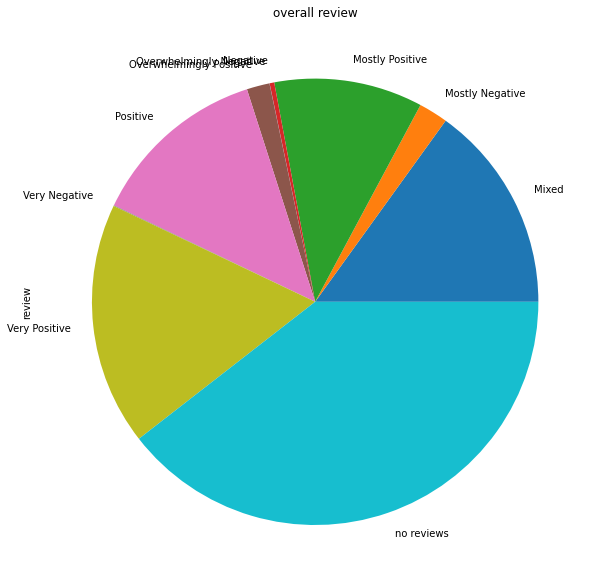

In [40]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_overall_review(new_df, fig, axes, "overall review", True)

According to Steam review rating system - The classification by positive precantage:

    95 - 99% : Overhwelmingly Positive
    94 - 80% : Very Positive
    80 - 99% + few reviews: Positive
    70 - 79% : Mostly Positive
    40 - 69% : Mixed
    20 - 39% : Mostly Negative
    0 - 39% + rew reviews: Negative
    0 - 19% : Very Negative
    0 - 19% + many reviews: Overwhelmingly Negative
    
Most of our games are rated as positive, as expected from a games store like Steam.

### 2. Release year

In [41]:
def pie_chart_release_year_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequent_elements(df, 'year')
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="year", title=title)

release year
1997        1
1998        1
1999        2
2000        2
2001        2
2002        1
2003        2
2004        6
2005        2
2006       54
2007       86
2008      113
2009      304
2010      244
2011      254
2012      336
2013      435
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
2023       15
2024        6
2026        3
2030        4
2033        1
2041        1
Name: year, dtype: int64


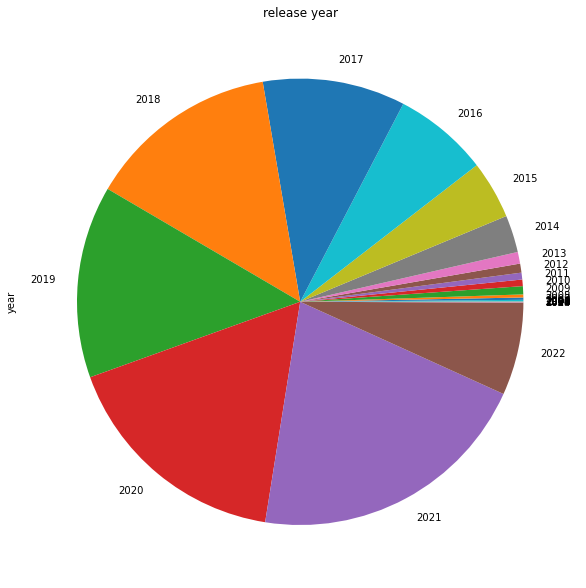

In [42]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_release_year_investigation(new_df, fig, axes, "release year", True)

We were positively impressed by this graph. It shows a pretty big variety of release years.

We assumed that most of the games offered for sale would be from the last few years, but we were impressed that there are a generous number of games from over 4 years ago.

But, we also noticed some outliers that we should handle.

The release date should be 2022 or below, since we are in 2022. We would also like to remvoe data from 2005 and below since it might not be relevant anymore.

##### Remove Release Year Outliers

/home/yuval/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

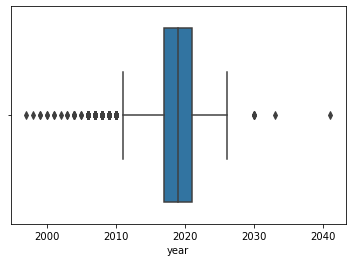

In [43]:
sns.boxplot(new_df.year)

In [44]:
def drop_year_outliers(df, min_year):
    df_centered = df.drop(df[df.year > 2022].index).copy()
    df_centered = df_centered.drop(df_centered[df_centered.year <= min_year].index) 
    return df_centered

/home/yuval/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

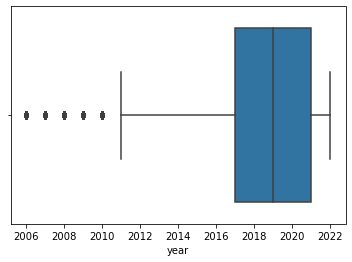

In [45]:
df_no_outliers = drop_year_outliers(new_df, 2005)

sns.boxplot(df_no_outliers.year)

Let's try to drop rows with a release date of 2013 and below.

/home/yuval/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

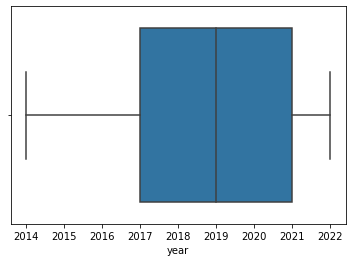

In [46]:
df_no_outliers = drop_year_outliers(new_df, 2013)

sns.boxplot(df_no_outliers.year)

It looks like there aren't any outliers.

Let's compare the changes:

include outliers
1997        1
1998        1
1999        2
2000        2
2001        2
2002        1
2003        2
2004        6
2005        2
2006       54
2007       86
2008      113
2009      304
2010      244
2011      254
2012      336
2013      435
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
2023       15
2024        6
2026        3
2030        4
2033        1
2041        1
Name: year, dtype: int64
---
without outliers
2014     1383
2015     2164
2016     3538
2017     5314
2018     7138
2019     7165
2020     8745
2021    10668
2022     3455
Name: year, dtype: int64


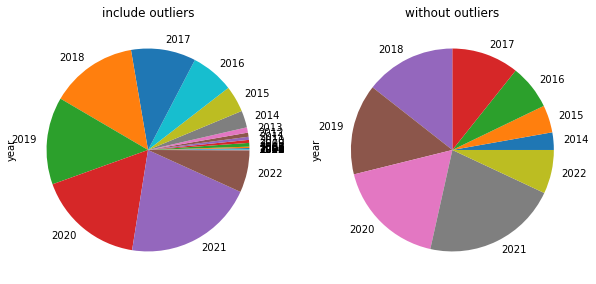

In [47]:
fig, axes = plt.subplots(1,2, figsize=(10, 40))

pie_chart_release_year_investigation(new_df, fig, axes[0], "include outliers", True)
print("---")
pie_chart_release_year_investigation(df_no_outliers, fig, axes[1], "without outliers", True)

Our data is much cleaner now.

In [48]:
# update our dataset with the balanced data
new_df = df_no_outliers

### 3. Amount of games with and without discount

First, we will create a new column that will indicate whether the game is on sale or not.

In [49]:
def pie_chart_discount_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = amount_of_discounts(df)
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="discount", title=title)

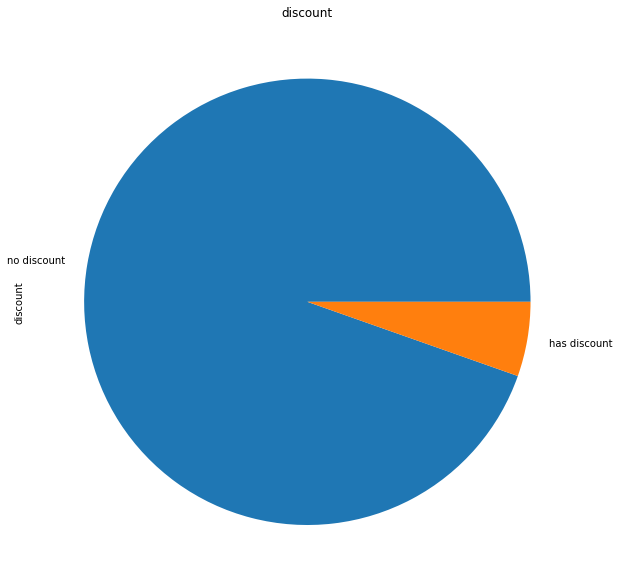

In [50]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_discount_investigation(new_df, fig, axes, "discount", False)

After analyzing this graph, we can understand that our data needs to be a bit more balanced.

The amount of data for games without a discount is much higher than the number of games with a discount.

We will have to adjust our data and balance it by duplicating the game data with a discount and presenting oversampling.

##### Oversampling
It randomly duplicates data in the minority class.

In [51]:
def preform_oversampling_has_discount(df):
    
    edited_df = add_has_discount_col(df)
    
    oversample = RandomOverSampler(sampling_strategy=0.5)
    oversample_df, oversample_has_discount = oversample.fit_resample(edited_df, edited_df['has_discount'])
    
    return oversample_df

In [52]:
oversample_df = preform_oversampling_has_discount(new_df)

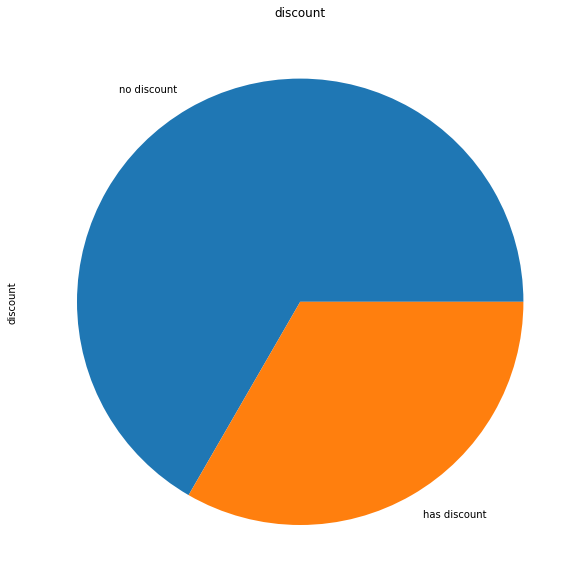

In [53]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_discount_investigation(oversample_df, fig, axes, "discount", False)

It looks much better. It seems like our data is balanced now.

By comparing both pie charts before and after oversampling, we can witness the improvement:

before oversampling
no discount     46896
has discount     2674
dtype: int64
after oversampling
no discount     46896
has discount    23448
dtype: int64


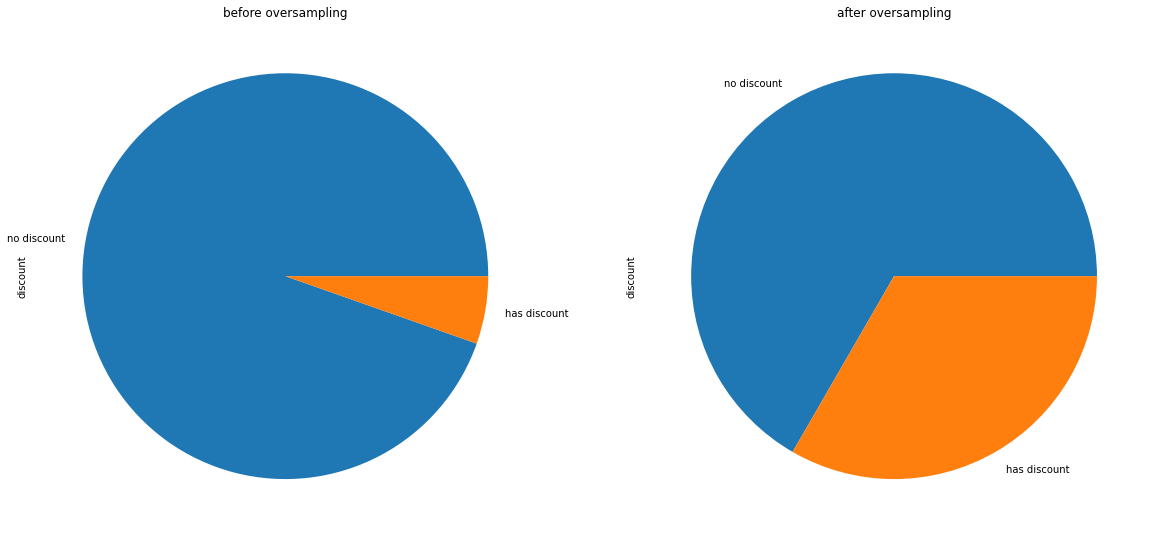

In [54]:
fig, axes = plt.subplots(1,2, figsize=(20, 30))

pie_chart_discount_investigation(new_df, fig, axes[0], "before oversampling", True)
pie_chart_discount_investigation(oversample_df, fig, axes[1], "after oversampling", True)

In [55]:
# update our dataset with the balanced data
new_df = oversample_df

### 4. Price

In [56]:
def pie_chart_price_investigation(df, fig, axes, title, show_data):

    sr_freq_directors = get_frequent_elements(df, 'price')
    
    if show_data:
        print (title)
        print (sr_freq_directors)

    sr_freq_directors.plot(kind='pie', ax=axes, ylabel="price", title=title)

overall review
0.00       6685
3.15         21
3.16          1
3.20         12
3.24          1
           ... 
449.95        3
564.95        1
749.95       22
1450.00       1
1850.00       1
Name: price, Length: 554, dtype: int64


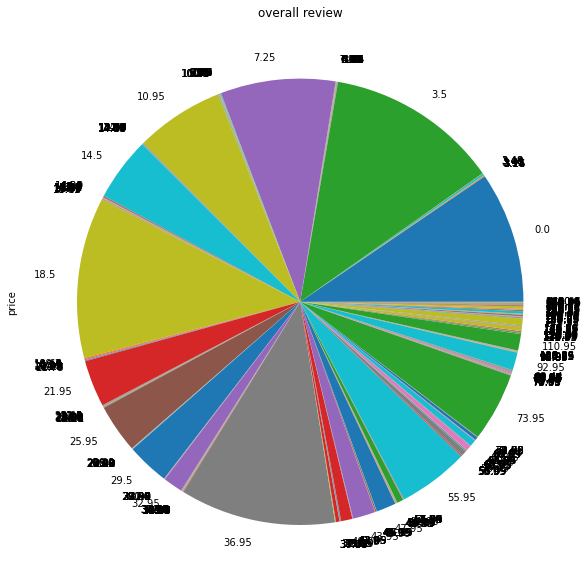

In [57]:
fig, axes = plt.subplots(1,1, figsize=(10, 40))

pie_chart_price_investigation(new_df, fig, axes, "overall review", True)

Let's check if we have any outliers:

/home/yuval/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

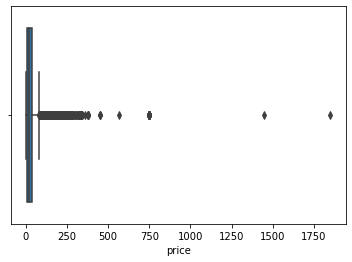

In [58]:
sns.boxplot(new_df.price)

##### Remove Price Outliers

In [59]:
def drop_price_outliers(df, max_price):
    df_centered = df.drop(df[df.price > max_price].index).copy()
    return df_centered

/home/yuval/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

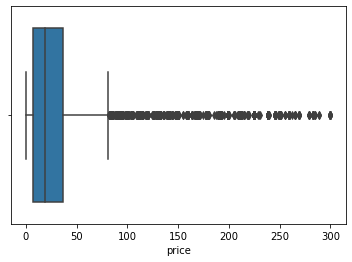

In [60]:
df_no_price_outliers = drop_price_outliers(new_df, 300)

sns.boxplot(df_no_price_outliers.price)

We decided that this was a good cut for our data. 
We would like to train our model with games that cost 300₪ or less.

Price with outlier
0.00       6685
3.15         21
3.16          1
3.20         12
3.24          1
           ... 
449.95        3
564.95        1
749.95       22
1450.00       1
1850.00       1
Name: price, Length: 554, dtype: int64
Price without outlier
0.00      6685
3.15        21
3.16         1
3.20        12
3.24         1
          ... 
279.00       5
283.00      14
284.95       2
289.00       2
299.95      12
Name: price, Length: 541, dtype: int64


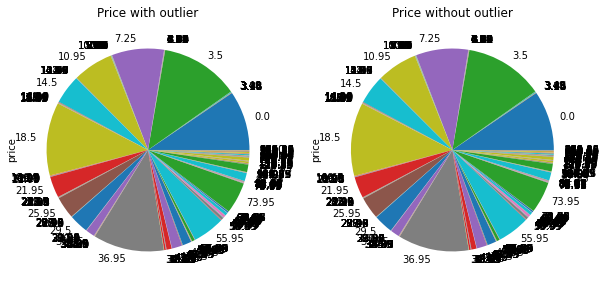

In [61]:
fig, axes = plt.subplots(1,2, figsize=(10, 40))

pie_chart_price_investigation(new_df, fig, axes[0], "Price with outlier", True)
pie_chart_price_investigation(df_no_price_outliers, fig, axes[1], "Price without outlier", True)

In [62]:
# update our dataset with the balanced data
new_df = df_no_price_outliers

Now we can see clearly that our data is balanced and ready for investigation.

In [63]:
def drop_support_column(df, col_name):
    return df.drop(col_name, axis = 1).copy()

We've finished our data handling. We've handled outliers and unbalanced our data.

Final results:

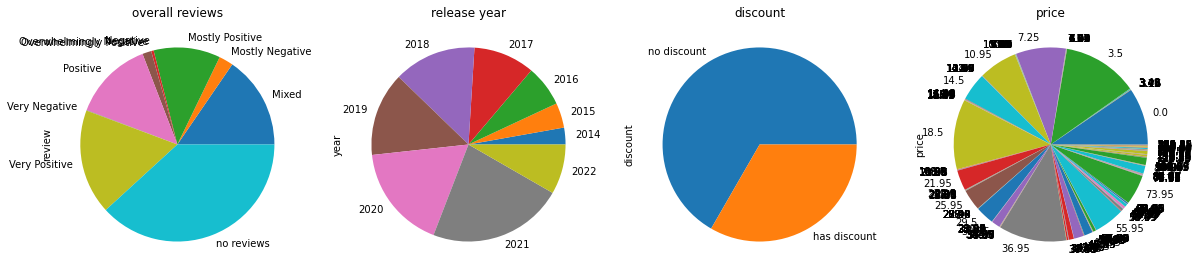

In [65]:
fig, axes = plt.subplots(1,4, figsize=(20, 30))

pie_chart_overall_review(new_df, fig, axes[0], "overall reviews", False)
pie_chart_release_year_investigation(new_df, fig, axes[1], "release year", False)
pie_chart_discount_investigation(new_df, fig, axes[2], "discount", False)
pie_chart_price_investigation(new_df, fig, axes[3], "price", False)

Let's check what is our state. We lost and added data during the data handling.

In [66]:
print(new_df.shape)

(70270, 16)


### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## EDA

In this section, we will investigate our data more carefully and try to learn him better in order to succeed in predicting more accurately.

##### Helper functions

The cross_tabulation function is a function to create and return a data frame of a cross-tabulation between the given 'col_name' column and the given 'other_col_name' column.

In [67]:
def cross_tabulation(df, col_name, other_col_name, normalize_val = "index"):
    return pd.crosstab(df[col_name], df[other_col_name], normalize=normalize_val)

'plot_cross_tabulation' is a function to create a cross tabulation for each of the columns in the given 'col_names' with the other given 'other_col_name' column.

The function plots a 'line' plot for each dataframe of the cross tabulation.

In [68]:
def plot_cross_tabulation(df, col_names, other_col_name, kind_val):
    fig, axes = plt.subplots(1,len(col_names), figsize=(20,5))
    i = 0
    for col in col_names:
        crosstb = cross_tabulation(df, col, other_col_name)
        crosstb.plot(kind=kind_val, ax=axes[i])
        i = i + 1

'get_highly_correlated_cols' function to return two arrays:
* 'correlations'
    - An python list, containing the correlation values for highly correlated columns from the given 'df' dataframe.
* 'tuple_arr'  
    - A python list containing two-dimensional tuples represents two columns with a high correlation.
        * Two columns are considered correlated if the value of the Pearson correlation coefficient of these columns is >= 0.5. 
        * Only one corresponding pair should be returned.
        * Don't forget to filter for self-correlation (of a column with the same column).

In [69]:
def get_highly_correlated_cols(df):
    tuple_arr = []
    correlations = []
                    
    discount_idx = df.columns.get_loc('discount') 
    for col in df.columns:
        col_idx = df.columns.get_loc(col)
        if col != 'discount' and col != 'has_discount' and col != 'price_discount':
            corr = df[col].corr(df['discount'], method='pearson')
            if abs(corr) >= 0.03:
                print (corr)
                tup = (col_idx, discount_idx)
                tuple_arr.append(tup)
                correlations.append(corr)
            
    
    return correlations, tuple_arr

'plot_high_correlated_scatters' function to plot scatter plots for each column pair, of the given 'df' dataframe, which has a high Pearson correlation coefficient (>=0.5).

Uses the 'get_highly_correlated_cols', which you've already implemented, to get the highly correlated column pair numbers.

In [70]:
def plot_high_correlated_scatters(df):    
    i = 0
    correlations, tuple_arr = get_highly_correlated_cols(df)
    
    fig, axes = plt.subplots(1,len(correlations), figsize=(20,5))
    for pair in tuple_arr:
        col_name_lt, col_name_rt = df.columns[pair[0]], df.columns[pair[1]]
        title = "corr('%s', '%s')=%4.2f" %(col_name_lt, col_name_rt, correlations[i]) 
        df.plot(col_name_lt, col_name_rt, kind="scatter", ax=axes[i], title = title)
        i = i + 1

#### Correlation between two categorial variables

Let's check if there is a connection between the release year and overall review with whether the game has a discount or not.

For displaying correlation between categorial columns, we used cross tabulation.

##### line graph

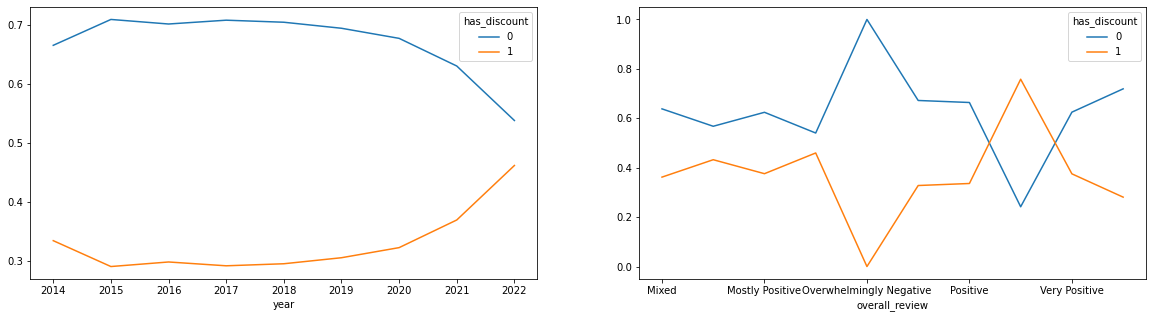

In [71]:
plot_cross_tabulation(new_df, ['year', 'overall_review'], 'has_discount', 'line')

We can also see the results using bar graphs:

##### bar graph

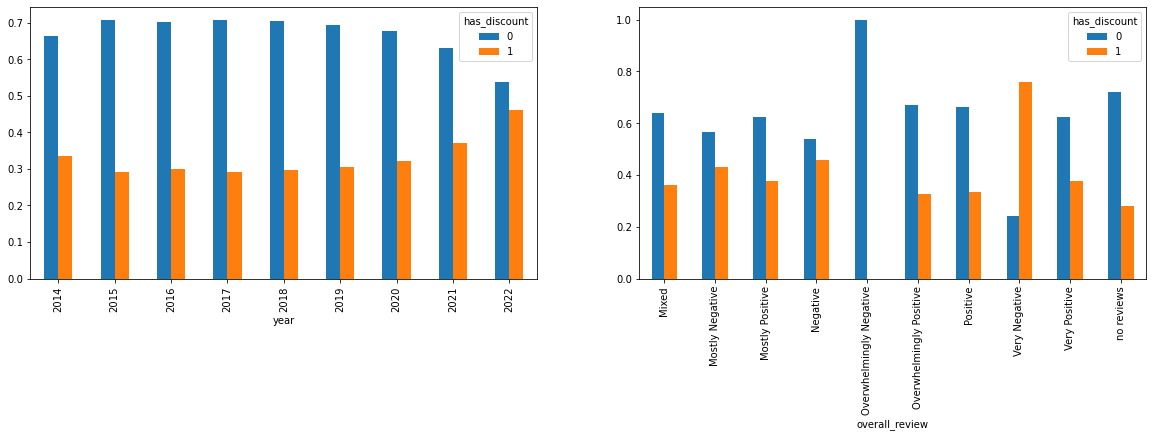

In [72]:
plot_cross_tabulation(new_df, ['year', 'overall_review'], 'has_discount', 'bar')

By investigating these graphs, we can understand that there is a connection between the release year and if the game is on sale or not, and also between the percentage of positive reviews.

The newer the game the possiblity for it to be on sale is higher and if it's positive reviews precentage is around 5% - 15%.

##### Chi

We are investigating how strong the connection is between release year and overall_review with the has_discount column.

In [73]:
ct = cross_tabulation(new_df, 'has_discount', 'year', False)
chi2_contingency(ct)

(733.2107125597605,
 5.05034017899432e-153,
 8,
 array([[ 1312.17737299,  1942.26254447,  3213.10099616,  4784.64676249,
          6441.53739861,  6540.88416109,  8157.7693895 , 10568.09520421,
          3892.52617049],
        [  655.82262701,   970.73745553,  1605.89900384,  2391.35323751,
          3219.46260139,  3269.11583891,  4077.2306105 ,  5281.90479579,
          1945.47382951]]))

We found that the p_value is lower than 0.05, then we can understand that there is a very strong connection between has_discount and the game's release year.

In [74]:
ct = cross_tabulation(new_df, 'has_discount', 'overall_review', False)
chi2_contingency(ct)

(679.9850228135756,
 1.3870990953948998e-140,
 9,
 array([[7.23164420e+03, 1.11815115e+03, 5.21137111e+03, 1.90025687e+02,
         2.66702718e+00, 6.97427608e+02, 6.27084766e+03, 4.13389213e+01,
         8.19110723e+03, 1.78984194e+04],
        [3.61435580e+03, 5.58848854e+02, 2.60462889e+03, 9.49743134e+01,
         1.33297282e+00, 3.48572392e+02, 3.13415234e+03, 2.06610787e+01,
         4.09389277e+03, 8.94558059e+03]]))

We can see here that there is also a connection between has_discount and overall_review

#### Correlation between a categorial variable and a numberic continuous variable

We've learned about the effects of release year and positive reviews of whether the game is on sale or not. Let's investigate the correlation between those parameters and the precantage of the discount.

year
2014    24.466972
2015    20.178510
2016    19.577713
2017    18.334866
2018    18.213849
2019    17.382671
2020    16.920883
2021    18.518675
2022    16.071600
Name: discount, dtype: float64

<AxesSubplot:xlabel='year'>

Text(0, 0.5, 'Discount precentage')

Text(0.5, 1.0, 'Correlation between release year and the discount precentage')

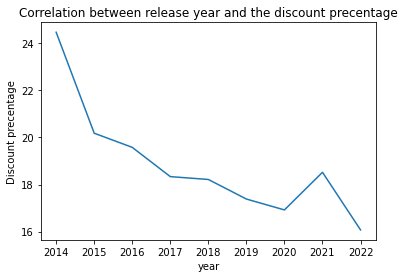

In [75]:
new_df.groupby('year').discount.mean()
new_df.groupby('year').discount.mean().plot(kind='line')
plt.ylabel('Discount precentage')
plt.title("Correlation between release year and the discount precentage")

As we can see from this graph, The older the game, the bigger the discount it might have. But let's not forget that the older the game, the probability of having a discount is lower.

##### histogram

<AxesSubplot:>

Text(0.5, 0, 'discount')

Text(0, 0.5, 'frequency')

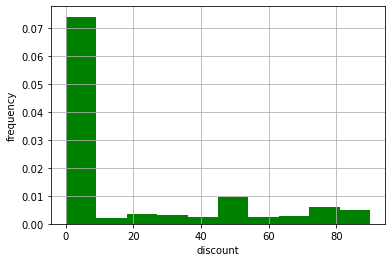

In [76]:
new_df.discount.hist(density=True, color="green")
plt.xlabel('discount')
plt.ylabel('frequency')

After investigating the histogram results, we can see that our histograma is leaning toward the left. 

We are pretty satisfied with the outcomes. It looks like the frequency of no discount is much higher, but it's because the game with discounts has many levels of discounts and we can see clearly that the frequency of 50% discount is higher than the other discount percentages.

##### kernel density plot

We can also see the results using a kernel density plot, and by comparing it to the positive review precantage, it looks like this:

<AxesSubplot:xlabel='discount', ylabel='Density'>

Text(0.5, 0, 'discount & positive review precentage')

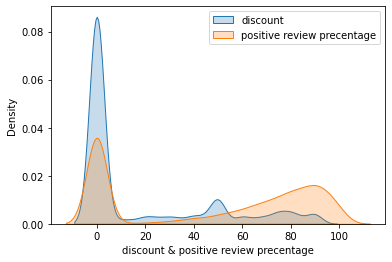

In [77]:
ax = sns.kdeplot(new_df.discount, shade=True)
sns.kdeplot(new_df.percentage_positive_total_reviewed, shade=True)

ax.set_xlabel("discount & positive review precentage")
plt.legend(title="", labels=['discount','positive review precentage'])

From the results shown here, we can see clearly that there is some connection between the discount and the positive review.
We can see that when there is no discount, the positive reviews are higher.

##### box plot

/home/yuval/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='discount'>

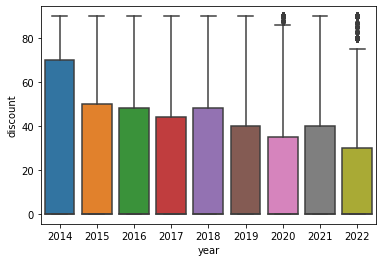

In [78]:
sns.boxplot(new_df.year, new_df.discount)

It looks like in 2022 we have some outliers, which means that there are some high discount percentage values compared to the average discount during 2022. We can also learn that the high discounts can be found in games that were released in 2014.

##### violin plot

Let's combine the box plot with the kerenl density plot to one violin plot:

/home/yuval/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='discount'>

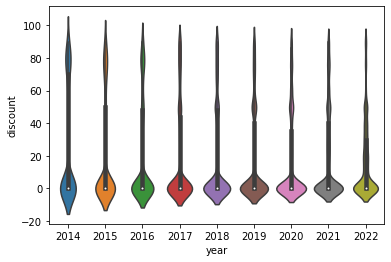

In [79]:
sns.violinplot(new_df.year, new_df.discount)

##### line plot

Here we can see the averages of both discount and positive reviews in one line plot ordered by release year.

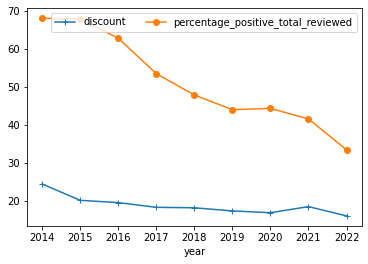

In [80]:
plot_df = new_df.groupby(['year']).mean()[['discount', 'percentage_positive_total_reviewed']]
plot_df.plot(style=['+-','o-']).legend(ncol=2)

#### Correlation between two numberic continuous variables

percentage_positive_total_reviewed
0      15.084013
3       0.000000
4       0.000000
5      43.076923
6       0.000000
         ...    
96     13.356926
97     15.412304
98      8.659686
99     13.357143
100    16.017680
Name: discount, Length: 99, dtype: float64

<AxesSubplot:xlabel='percentage_positive_total_reviewed'>

Text(0, 0.5, 'Discount precentage')

Text(0.5, 1.0, 'Correlation between positive reviews and the discount precentage')

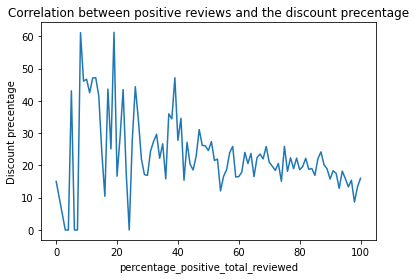

In [81]:
new_df.groupby('percentage_positive_total_reviewed').discount.mean()
new_df.groupby('percentage_positive_total_reviewed').discount.mean().plot(kind='line')  #kind=line is used in order to obtain a line plot\n",
plt.ylabel('Discount precentage')
plt.title("Correlation between positive reviews and the discount precentage")

This graph shows that when the positive reviews are around 5–20%, the bigger the discount. It's a bit similar to the graph above that represents that the chances of having a discount are higher when the positive reviews are between 5-15%.

#### Multi dimantional visualizations

<AxesSubplot:xlabel='price', ylabel='percentage_positive_total_reviewed'>

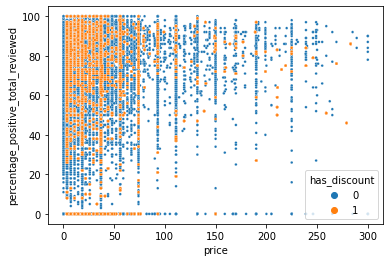

In [82]:
sns.scatterplot(x = 'price', y = 'percentage_positive_total_reviewed', s=7, hue='has_discount', data=new_df)

By investigating this graph, we can understand that when the price is low and the positive reviews are high, then it is more likely that the game has a discount.

Text(0.5, 0, 'positive reviews')

Text(0.5, 0.5, 'price')

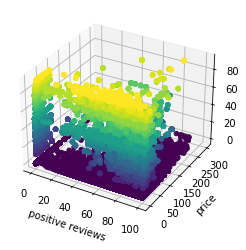

In [83]:
ax = plt.axes(projection="3d")
xdata = new_df.percentage_positive_total_reviewed
ydata = new_df.price
zdata = new_df.discount

plt.xlabel('positive reviews')
plt.ylabel('price')

ax.scatter3D(xdata, ydata, zdata, c=zdata, depthshade=False)

Similar to the previous graph, when the price is low and the positive reviews are high, the higher the discount.

### Summarizing the results

1. It's more likely to have a discount on new games than on older games.
2. The lower the discount percentage, the later the release date.
3. When the price is low and the positive reviews are high, then it's more likely to have a discount and the discount percentage will be higher.
4. There is a connection between the release year and the overall reviews with whether the game has a discount or not.

Our data is balanced, and we could find connections between the different parameters with the discount variable. We can now prepare our data for the machine learning model.

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Data preparation

In this section, we prepare our data to be ready to predict by converting it to a fully numeric value.

In [84]:
def factorize_column(col_name, dataset):
    return pd.factorize(dataset[col_name], sort=True)[0]

##### Title & Overall revirew - factorize

In [85]:
num_dataset = new_df.copy()
num_dataset['title'] = factorize_column('title', num_dataset)
num_dataset['overall_review'] = factorize_column('overall_review', num_dataset)

We no longer need the 'has_discount' and the 'price_discount' columns. Let's remove it:

In [86]:
def drop_unused_parameters(df, parameters):
    return df.drop(parameters, axis=1).copy()

### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

## Model

At the beginning of the semester, we predicted that we'd arrive here.

But, seriously, in this section we used several algorithms in order to predict our data and search for the best one for our goal.

We tried to predict 2 things:
1. Predict whether or not the game will be on sale.
2. Estimate the precentage of the discount.

Those predictions sperate into logistic and linear regression.
* The first predict we mention uses logistic regression. We used several algorithms to predict our data, such as KNN, Decition Tree, Random Forest, and NayievBase.

* The second prediction we mentioned uses linear regression.

#### helper functions

Split data to base and target

In [87]:
def split_base_traget(df, target_col):
    return df.drop(target_col, axis=1), df[target_col]

Split dataset to train and test

In [88]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    X, y = split_base_traget(dataset, label_column)
    return train_test_split(X, y, random_state=rand_state, test_size=test_ratio)

Returns the predicted y values

In [89]:
def predict_model(trained_model, X_test):
    return trained_model.predict(X_test)

##### Scaling functions

We used the Min_Max scaler in order to scale our dataframe before using it in our model.

In [90]:
def scale_dataset(scaler, df):
    return pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

In [91]:
def run_standard_scaler(df):
    scaler = StandardScaler()
    return scale_dataset(scaler, df)

Run MinMax scaler

In [92]:
def run_min_max_scaler(df):
    scaler = MinMaxScaler()
    return scale_dataset(scaler, df)

##### Logistical Regrassion functions

Train the model using Logistical regression

In [93]:
def train_model_logistic(X_train, y_train):
    reg = linear_model.LogisticRegression()
    return reg.fit(X_train,y_train)

Run F1 score to evaluate the model's performance. We are using the F1 score to evaluate the logstical regression.

In [94]:
def evaluate_performance_f1(y_test, y_predicted):
    return metrics.f1_score(y_test, y_predicted)

Return all the games with a discount from a given dataset.

In [95]:
def get_games_with_discount(df):
    return num_dataset[df.has_discount == 1]

##### Linear Regrassion functions

Train the model using Linear regression

In [96]:
def train_model_linear(X_train, y_train):
    reg = linear_model.LinearRegression()
    return reg.fit(X_train, y_train)

Run R2 score to evaluate the model's performance. We are using the R2 score to evaluate the linear regression.

In [97]:
def evaluate_performance_r2(y_test, y_predicted):
    return metrics.r2_score(y_test, y_predicted)

#### Set Parameters

In [98]:
test_ratio, rand_state = 0.2, 20

### Logistical Regrassion Model

Predict which of the games will have a discount.

#### Prepare the dataset

In [99]:
has_discount_dataset = drop_unused_parameters(num_dataset, ['discount', 'price_discount'])

Scaling the model

In [100]:
scaled_df = run_min_max_scaler(has_discount_dataset)
scaled_df.head()

,title,win_support,mac_support,linux_support,vr_only,vr_supported,price,overall_review,percentage_positive_total_reviewed,total_reviewed,day,month,year,has_discount
0,0.051670,1.0,0.0,0.0,0.0,0.0,0.000000,0.888889,0.86,0.217799,0.100000,0.909091,0.750,0.0
1,0.256448,1.0,0.0,0.0,0.0,0.0,0.830138,0.888889,0.89,0.169661,0.766667,0.090909,1.000,0.0
2,0.447728,1.0,0.0,0.0,0.0,0.0,0.663444,0.888889,0.94,0.007847,0.133333,0.272727,1.000,0.0
3,0.587098,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.56,1.000000,0.666667,1.000000,0.375,0.0
4,0.540700,1.0,0.0,0.0,0.0,0.0,0.366561,0.888889,0.80,0.043832,0.333333,0.636364,0.875,0.0


#### Training the model 

In [101]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = split_to_train_and_test(scaled_df, 'has_discount', test_ratio, rand_state)

In [102]:
trained_model_scaled = train_model_logistic(X_train_scaled, y_train_scaled)

Classifiers:

In [103]:
def perform_classifiers(X_train, X_test, y_train, y_test):
    clf1 = tree.DecisionTreeClassifier()
    clf2 = RandomForestClassifier()
    clf3 = GaussianNB()
    clf4 = KNeighborsClassifier()
    
    alg_names = ["DecisionTree", "RandomForest", "NayievBase", "KNN"]
    
    for indx, clf in enumerate([clf1, clf2, clf3, clf4]):
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        
        print(f"-----------{alg_names[indx]}-----------")
        print(f"accuracy on train is {metrics.accuracy_score(y_true=y_train, y_pred= y_pred_train)}")
        print(f"accuracy on test is {metrics.accuracy_score(y_true=y_test, y_pred= y_pred)}")
        print(f"confusion matrix")
        print(metrics.confusion_matrix(y_test, y_pred))

In [104]:
perform_classifiers(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

-----------DecisionTree-----------
accuracy on train is 1.0
accuracy on test is 0.9587306105023481
confusion matrix
[[8831  578]
 [   2 4643]]
-----------RandomForest-----------
accuracy on train is 1.0
accuracy on test is 0.9960865234097054
confusion matrix
[[9356   53]
 [   2 4643]]
-----------NayievBase-----------
accuracy on train is 0.3405969830653195
accuracy on test is 0.3375551444428632
confusion matrix
[[ 126 9283]
 [  27 4618]]
-----------KNN-----------
accuracy on train is 0.9203607513875053
accuracy on test is 0.8814572363739861
confusion matrix
[[7836 1573]
 [  93 4552]]


After investigating the different classifiers, it seems like the Random Forest was the most accurate. But we also performed oversampling and this might be the reason. The same apply to the decision tree. Let's use KNN to predict our data.

In [105]:
clf = KNeighborsClassifier()
clf.fit(X_train_scaled, y_train_scaled)

y_pred = clf.predict(X_test_scaled)

KNeighborsClassifier()

In [106]:
eval_res_scaled = evaluate_performance_f1(y_test_scaled, y_pred)
print(f"accuracy on test is {metrics.accuracy_score(y_true=y_test_scaled, y_pred= y_pred)}")
metrics.confusion_matrix(y_test_scaled, y_pred)
eval_res_scaled

accuracy on test is 0.8814572363739861


array([[7836, 1573],
       [  93, 4552]])

0.8453110492107707

In [107]:
res_df = pd.DataFrame({"true" : y_test_scaled, "pred" : y_pred})
fails = res_df[res_df.true != res_df.pred]
fails

,true,pred
14116,0.0,1.0
45926,0.0,1.0
8212,0.0,1.0
30466,0.0,1.0
38606,0.0,1.0
...,...,...
65966,1.0,0.0
19316,0.0,1.0
18013,0.0,1.0
235,0.0,1.0


Not bad... Let's try to find the best hyperparameters for KNN.

In [108]:
def find_best_KNN_param():
    clf = KNeighborsClassifier()
    params = {"n_neighbors":[3, 5, 10]}
    clfCV = GridSearchCV(clf, params, cv= 10)

    clfCV.fit(X_train_scaled, y_train_scaled)
    
    print(f"best params: {clfCV.best_params_}")
    print(f"best score: {clfCV.best_score_}")
    
    return clfCV.best_params_

In [109]:
# bestK = find_best_KNN_param()
# clf = KNeighborsClassifier(n_neighbors= bestK)

We've found out that 3 is the best hyper parameter and used it as our parameter in the KNN algorithm.
#### In this case, the best score is too high, which might imply that we have overfitted.
This sounds like a reasonable case due to the fact that the algorithm is looking for 3 closest neighbors and we performed oversampling that duplicated some of our data.

We will use KNN with 7 neighbors.

- We are marking this as a comment to avoid running it every time (it takes a lot of time).

In [110]:
clf = KNeighborsClassifier(n_neighbors= 7)
clf.fit(X_train_scaled, y_train_scaled)

KNeighborsClassifier(n_neighbors=7)

#### Predict

In [111]:
y_pred = clf.predict(X_test_scaled)

#### Evaluate

In [112]:
eval_res_scaled = evaluate_performance_f1(y_test_scaled, y_pred)
print(f"accuracy on test is {metrics.accuracy_score(y_true=y_test_scaled, y_pred= y_pred)}")
metrics.confusion_matrix(y_test_scaled, y_pred)
eval_res_scaled

accuracy on test is 0.8461647929415114


array([[7468, 1941],
       [ 221, 4424]])

0.8036330608537694

#### This results makes much more sense!

### Linear Regression

Let's try to predict the discount percentage for every game with a discount.

Prepare...

In [113]:
discount_df = get_games_with_discount(num_dataset)
discount_df = drop_unused_parameters(num_dataset, ['has_discount', 'price_discount'])

Train...

In [114]:
X_train_discount, X_test_discount, y_train_discount, y_test_discount = split_to_train_and_test(discount_df, 'discount', test_ratio, rand_state)
trained_discount_model = train_model_linear(X_train_discount, y_train_discount)

Predict...

In [115]:
y_discount_pred = trained_discount_model.predict(X_test_discount)

Evaluate...

In [116]:
eval_res_discount = evaluate_performance_r2(y_test_discount, y_discount_pred)
eval_res_discount

0.015925744489871718

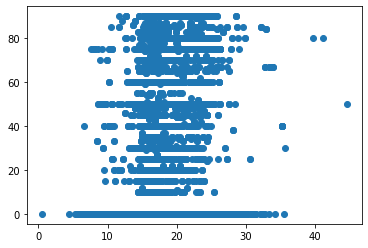

In [117]:
plt.scatter(y_discount_pred, y_test_discount)

This result is too scattered around. We can understand that we don't have enough parameters to determine the game discount value.